# ItalianSignNet study

### Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from PIL import Image
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import albumentations as A
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import pickle
import glob
from sklearn.metrics import classification_report

import logging
logging.getLogger('lime').setLevel(logging.ERROR)


2025-07-09 10:04:23.524240: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-09 10:04:23.580099: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-09 10:04:23.580161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-09 10:04:23.585632: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-09 10:04:23.599135: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-09 10:04:23.600097: I tensorflow/core/platform/cpu_feature_guard.cc:1

### Boiterplate

In [2]:
DATASET_NAME = 'dataset_20250626_135853_eps_100_augmented'
DATASET_BASE_PATH = '/kaggle/input' if os.path.isdir('/kaggle/working') else '/workspace/src/dataset/artifacts'
DATA_DIR = f'{DATASET_BASE_PATH}/{DATASET_NAME}'
TRAIN_PATH = f'{DATA_DIR}/train'
TEST_PATH = f'{DATA_DIR}/test'
VAL_PATH = f'{DATA_DIR}/validation'

IMG_HEIGHT = 64
IMG_WIDTH = 64
CHANNELS = 3
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 30

# kaggle or docker kernel
WORSPACE_PATH = '/kaggle/working' if os.path.isdir('/kaggle/working') else '/workspace/src/models/notebook-workspace'
FORCE_TRAIN_MODELS=False

SEED = 42
np.random.seed(SEED)

CLASSES = { 
    0:'Speed limit (20km/h)',
    1:'Speed limit (30km/h)', 
    2:'Speed limit (50km/h)', 
    3:'Speed limit (60km/h)', 
    4:'Speed limit (70km/h)', 
    5:'Speed limit (80km/h)', 
    6:'End of speed limit (80km/h)', 
    7:'Speed limit (100km/h)', 
    8:'Speed limit (120km/h)', 
    9:'No passing', 
    10:'No passing veh over 3.5 tons', 
    11:'Right-of-way at intersection', 
    12:'Priority road', 
    13:'Yield', 
    14:'Stop', 
    15:'No vehicles', 
    16:'Veh > 3.5 tons prohibited', 
    17:'No entry', 
    18:'General caution', 
    19:'Dangerous curve left', 
    20:'Dangerous curve right', 
    21:'Double curve', 
    22:'Bumpy road', 
    23:'Slippery road', 
    24:'Road narrows on the right', 
    25:'Road work', 
    26:'Traffic signals', 
    27:'Pedestrians', 
    28:'Children crossing', 
    29:'Bicycles crossing', 
    30:'Beware of ice/snow',
    31:'Wild animals crossing', 
    32:'End speed + passing limits', 
    33:'Turn right ahead', 
    34:'Turn left ahead', 
    35:'Ahead only', 
    36:'Go straight or right', 
    37:'Go straight or left', 
    38:'Keep right', 
    39:'Keep left', 
    40:'Roundabout mandatory', 
    41:'End of no passing', 
    42:'End no passing veh > 3.5 tons' 
}

In [3]:
import mlflow

def is_running_on_databricks():
    return os.environ.get("DATABRICKS_RUNTIME_VERSION") is not None

def configure_mlflow():
    if is_running_on_databricks():
        mlflow.set_tracking_uri("databricks")
        print("MLflow on Databricks")
    else:
        mlflow.set_tracking_uri("http://mlflow:5000")
        print("Local MLFlow")
        
configure_mlflow()
mlflow.set_experiment("traffic-signs-classification")


Local MLFlow


<Experiment: artifact_location='/mlflow/mlflow_data/mlruns/1', creation_time=1749295058439, experiment_id='1', last_update_time=1749295058439, lifecycle_stage='active', name='traffic-signs-classification', tags={}>

### Visualizing The Dataset

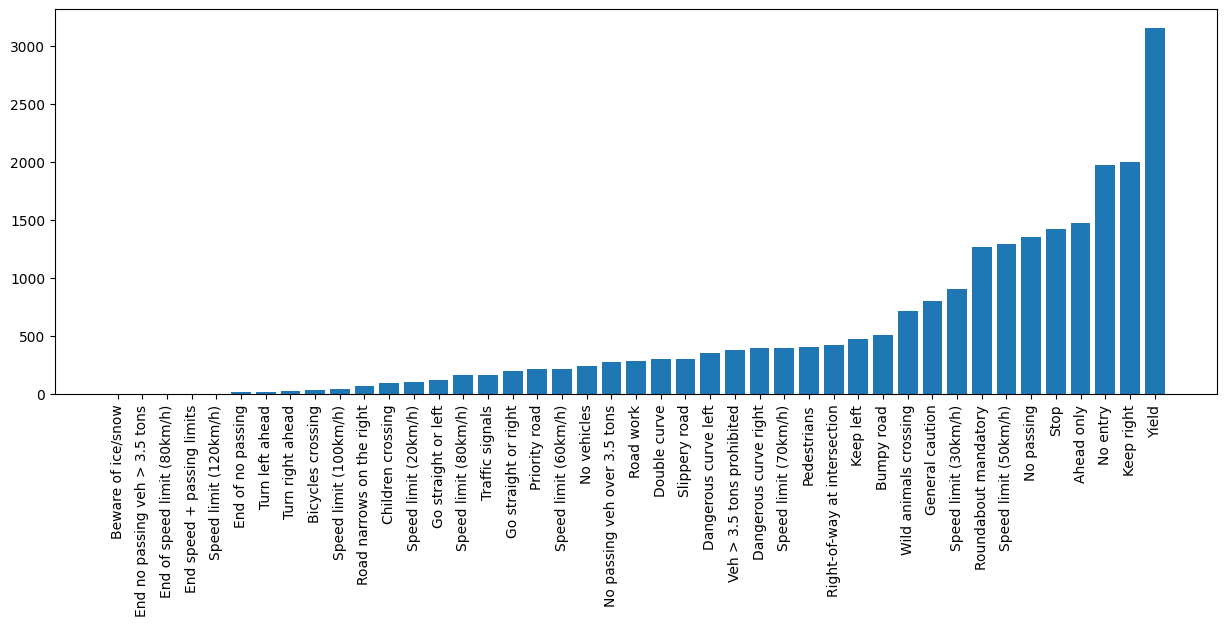

In [4]:
folders = os.listdir(TRAIN_PATH)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(TRAIN_PATH + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(CLASSES[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(15,5))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

### Albumentation visualitation

/tmp/ipykernel_20/4070005913.py:41: UserWarning: Argument(s) 'fog_coef' are not valid for transform RandomFog
  {"name": "Fog", "transform": A.RandomFog(p=1, fog_coef=0.8)},


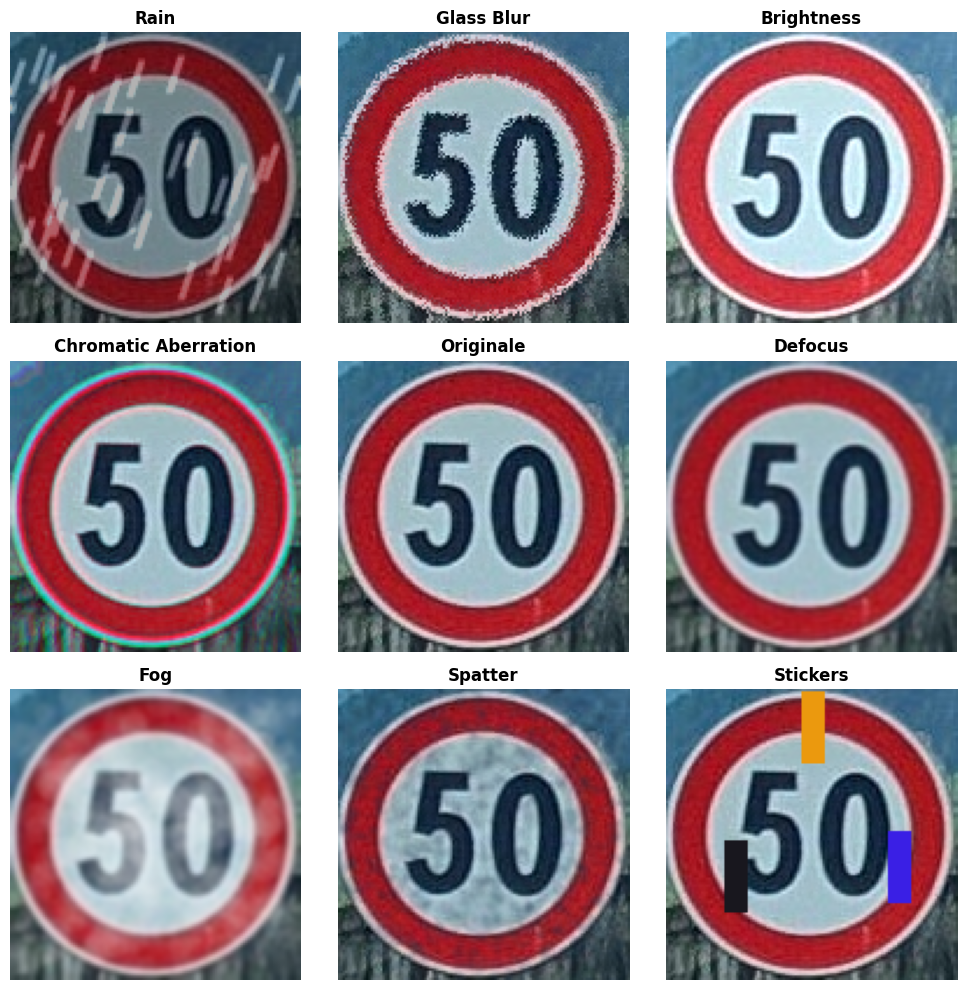

In [6]:
def show_albumentations_example(path):
    image_albumentations_example = cv2.imread(path)
    image_albumentations_example = cv2.cvtColor(image_albumentations_example, cv2.COLOR_BGR2RGB)

    transformations = [
        {"name": "Rain", "transform": A.RandomRain(
            slant_range=[-15, 15],
            drop_width=1,
            drop_color=[500, 500, 500],
            blur_value=3,
            brightness_coefficient=0.7,
            rain_type="default",
            p=1
        )},
        {"name": "Glass Blur", "transform": A.GlassBlur(
            sigma=0.2,
            max_delta=1,
            iterations=1,
            mode="fast",
            p=1
        )},
        {"name": "Brightness", "transform": A.RandomBrightnessContrast(
            brightness_limit=[-0.5, 0.2],
            contrast_limit=[-0.2, 0.2],
            brightness_by_max=True,
            ensure_safe_range=False,
            p=1
        )},
        {"name": "Chromatic Aberration", "transform": A.ChromaticAberration(
            primary_distortion_limit=[-0.5, 0.5],
            secondary_distortion_limit=[-0.3, 0.3],
            mode="random",
            interpolation=cv2.INTER_LINEAR,
            p=1
        )},
        {"name": "Defocus", "transform": A.Defocus(
            radius=[1, 5],
            alias_blur=[0.1, 0.5],
            p=1
        )},
        {"name": "Fog", "transform": A.RandomFog(p=1, fog_coef=0.8)},
        {"name": "Spatter", "transform": A.Spatter(
            mean=[0.25, 0.25],
            std=[0.2, 0.2],
            gauss_sigma=[1, 2],
            cutout_threshold=[0.58, 0.68],
            intensity=[0.6, 0.8],
            mode="mud",
            p=1
        )},
        {"name": "Stickers", "transform": A.GridDropout(
            holes_number_xy=[1, 3],
            ratio=0.25,
            random_offset=True,
            fill="random_uniform",
            p=1
        )}
    ]
    
    # Visualizzazione con griglia 3x3
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    
    # Mostra immagine originale al centro
    axes[1, 1].imshow(image_albumentations_example)
    axes[1, 1].set_title("Originale", fontsize=12, fontweight='bold')
    axes[1, 1].axis("off")
    
    positions = [(0,0), (0,1), (0,2), (1,0), 
                (1,2), (2,0), (2,1), (2,2)]
    
    for i, t in enumerate(transformations):
        row, col = positions[i]
        transformed_image = t["transform"](image=image_albumentations_example)['image']
        axes[row, col].imshow(transformed_image)
        axes[row, col].set_title(t["name"], fontsize=12, fontweight='bold')
        axes[row, col].axis("off")
    
    plt.tight_layout()
    plt.show()


show_albumentations_example(f"{TEST_PATH}/02/138649562181816_339.jpg")

## Collecting the Training Data

In [7]:
def process_image(image_path: str):
    try:
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError("Image is None")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        return image
    except Exception as e:
        print(f"Error in {image_path}: {e}")
        return None


def read_train_dataset_images():
    image_data = []
    image_labels = []
    for i in range(len(CLASSES)):
        path = os.path.join(TRAIN_PATH, f"{i:02d}")
    
        if not os.path.isdir(path):
            print(f'not exist {path}')
            continue

        images = os.listdir(path)
        for img in images:
            processed = process_image(os.path.join(path, img))
            if processed is not None:
                image_data.append(processed)
                image_labels.append(f"{i:02d}")
            else:
                print(f"Skipped: {img} in {path}")
    
    image_data = np.array(image_data)
    image_labels = np.array(image_labels)
    return image_data, image_labels

image_data, image_labels = read_train_dataset_images()
print(image_data.shape, image_labels.shape)

(22620, 64, 64, 3) (22620,)


### Shuffling the training data

In [8]:
def shuffle_training_data():
    shuffle_indexes = np.arange(image_data.shape[0])
    np.random.shuffle(shuffle_indexes)
    return image_data[shuffle_indexes], image_labels[shuffle_indexes]

image_data, image_labels = shuffle_training_data()

## Collecting validation set

In [9]:
X_train = image_data.astype('float32') / 255.

val_data = []
val_labels = []
for label_name in os.listdir(VAL_PATH):
    label_dir = os.path.join(VAL_PATH, label_name)
    if not os.path.isdir(label_dir):
        continue
    for img_file in os.listdir(label_dir):
        img_path = os.path.join(label_dir, img_file)
        processed = process_image(img_path)
        if processed is not None:
            val_data.append(processed)
            val_labels.append(int(label_name))
        else:
            print(f"Skipped invalid image: {img_path}")

X_val = np.array(val_data, dtype='float32') / 255.
val_labels = np.array(val_labels) 

print("X_train.shape", X_train.shape)
print("X_val.shape",   X_val.shape)

X_train.shape (22620, 64, 64, 3)
X_val.shape (4841, 64, 64, 3)


#### One hot encoding the labels

In [10]:
y_train = keras.utils.to_categorical(image_labels, len(CLASSES))
y_val = keras.utils.to_categorical(val_labels, len(CLASSES))
print("y_train.shape", y_train.shape)
print("y_val.shape",   y_val.shape)

y_train.shape (22620, 43)
y_val.shape (4841, 43)


## Making models

In [11]:
model_conv4 = keras.models.Sequential([ 
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,CHANNELS)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=48, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])
model_conv4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 30, 30, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 48)        13872     
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 64)        2

In [12]:
def create_model_conv3(input_shape=(IMG_HEIGHT,IMG_WIDTH,CHANNELS), num_classes=43):
    model = keras.models.Sequential([
        # Primo blocco - ridotto filters iniziali
        keras.layers.Conv2D(filters=12, kernel_size=(3,3), activation='relu', 
                           input_shape=input_shape),
        keras.layers.Conv2D(filters=24, kernel_size=(3,3), activation='relu'),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.1),  # Dropout leggero per regolarizzazione
        
        # Secondo blocco - filters moderati
        keras.layers.Conv2D(filters=48, kernel_size=(3,3), activation='relu'),
        keras.layers.Conv2D(filters=96, kernel_size=(3,3), activation='relu'),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),
        
        # Terzo blocco aggiuntivo per feature più complesse
        keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.25),
        
        # Classificatore ridotto drasticamente
        keras.layers.GlobalAveragePooling2D(),  # Sostituisce Flatten + Dense(512)
        keras.layers.Dense(128, activation='relu'),  # Molto più piccolo di 512
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        
        keras.layers.Dense(num_classes, activation='softmax')
    ], name='optimized_cnn_traffic_signs')
    
    return model

model_conv3 = create_model_conv3()
model_conv3.summary()

Model: "optimized_cnn_traffic_signs"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 12)        336       
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 24)        2616      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 24)        0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 30, 30, 24)        96        
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 24)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28,

### MobileNetV2

In [13]:
# MobileNetV2 con pesi pre-addestrati su ImageNet (ottimo per feature generiche)
# ImageNet contiene molte immagini di oggetti, veicoli e scene stradali
base = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS), 
    include_top=False, 
    weights='imagenet'
)
base.trainable = True

# Architettura migliorata
x = base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(43, activation='softmax')(x)

mobileNetV2 = models.Model(inputs=base.input, outputs=outputs, name="mobilenet_v2_traffic_signs")
mobileNetV2.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "mobilenet_v2_traffic_signs"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 32, 32, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 32, 32, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_rel

In [14]:
# Monitor learning by validation accuracy
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,                
    restore_best_weights=True,
    verbose=1                 
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6
)

In [15]:
def train_or_load_model(model_name: str, current_model):
    weights_path = os.path.join(WORSPACE_PATH, f'{model_name}.weights.h5')
    history_path = os.path.join(WORSPACE_PATH, f'history_{model_name}.pkl')

    if os.path.isfile(weights_path) and not FORCE_TRAIN_MODELS:
        print(f"[INFO] Caricamento pesi per {model_name} da {weights_path}")
        current_model.load_weights(weights_path)
        history = None
        if os.path.isfile(history_path):
            print(f"[INFO] Caricamento history per {model_name} da {history_path}")
            with open(history_path, 'rb') as f:
                history = pickle.load(f)
        else:
            print(f"[INFO] Nessuna history trovata per {model_name} da {history_path}")
    else:
        print(f"[INFO] Addestramento modello {model_name}")
        opt = Adam(learning_rate=LR)
        checkpoint = ModelCheckpoint(weights_path, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')
        current_model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )

        history = current_model.fit(
            x=X_train, 
            y=y_train,
            epochs=EPOCHS,
            validation_data=(X_val, y_val),
            callbacks=[early_stop, lr_scheduler, checkpoint]
        )

        with open(history_path, 'wb') as f:
            pickle.dump(history.history, f)

    return current_model, history

In [16]:
models_info = {}
model_configs = {
    'model_conv4': model_conv4,
    'model_conv3': model_conv3,
    'mobileNetV2': mobileNetV2,
}

for model_name, current_model in model_configs.items():
    model_with_weights, current_history = train_or_load_model(
        model_name=model_name,
        current_model=current_model
    )

    models_info[model_name] = {
        'model': model_with_weights,
        'history': current_history
    }

[INFO] Caricamento pesi per model_conv4 da /workspace/src/models/notebook-workspace/model_conv4.weights.h5
[INFO] Caricamento history per model_conv4 da /workspace/src/models/notebook-workspace/history_model_conv4.pkl
[INFO] Caricamento pesi per model_conv3 da /workspace/src/models/notebook-workspace/model_conv3.weights.h5
[INFO] Caricamento history per model_conv3 da /workspace/src/models/notebook-workspace/history_model_conv3.pkl
[INFO] Caricamento pesi per mobileNetV2 da /workspace/src/models/notebook-workspace/mobileNetV2.weights.h5
[INFO] Caricamento history per mobileNetV2 da /workspace/src/models/notebook-workspace/history_mobileNetV2.pkl


#### Visualize history graphs

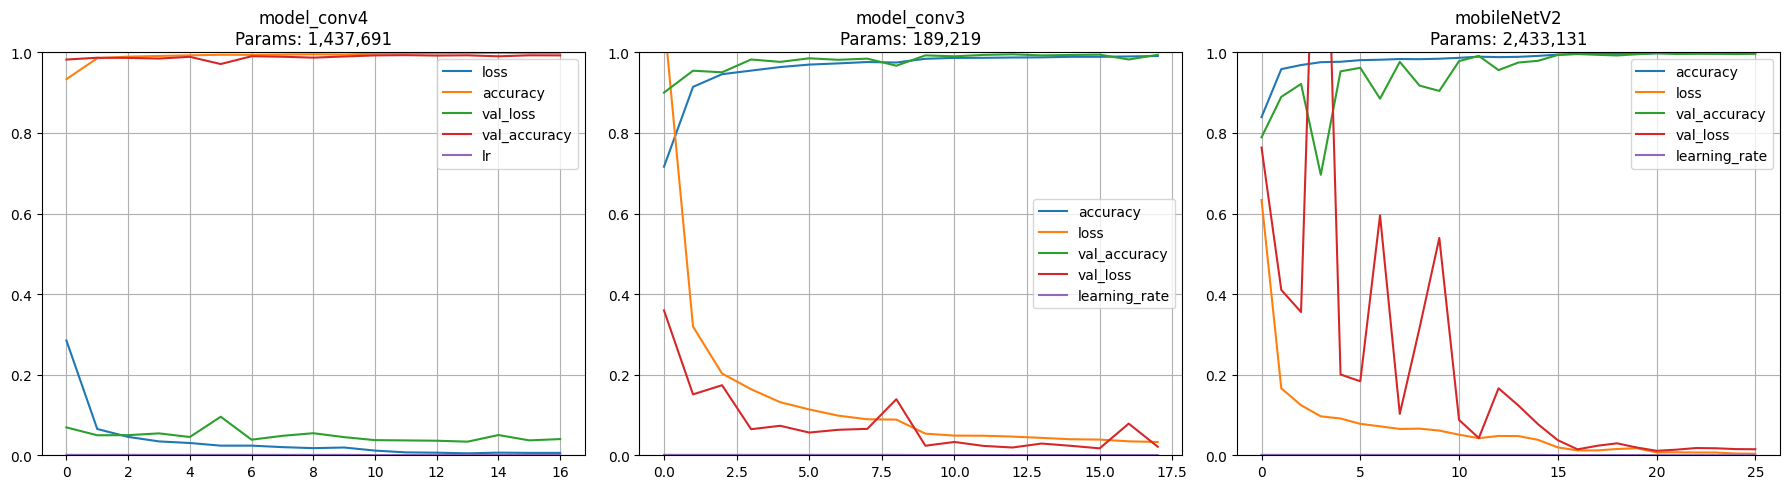

In [17]:
# Configura la griglia in base al numero di modelli
n_models = len(models_info)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))

# Garantisci che axs sia 2D anche se c'è solo una riga
if n_rows == 1:
    axs = np.array([axs]).reshape(1, -1)
elif n_cols == 1:
    axs = np.array([axs]).reshape(-1, 1)

for i, (model_name, info) in enumerate(models_info.items()):
    row = i // n_cols
    col = i % n_cols

    history = info['history']
    current_model = info['model']

    if history is not None:
        ax = axs[row][col]
        
        # Gestione dei diversi formati di history
        if isinstance(history, dict):
            # Caso history da addestramento (Keras)
            history_df = pd.DataFrame(history)
        elif hasattr(history, 'history') and isinstance(history.history, dict):
            # Caso History object (da model.fit())
            history_df = pd.DataFrame(history.history)
        else:
            # Altri casi (potrebbe essere già un DataFrame o altro)
            history_df = pd.DataFrame(history)
        
        # Plot dei dati
        history_df.plot(ax=ax)
        ax.set_title(f"{model_name}\nParams: {current_model.count_params():,}")
        ax.grid(True)
        ax.set_ylim(0, 1)

# Nasconde gli assi vuoti, se presenti
for j in range(i + 1, n_rows * n_cols):
    row = j // n_cols
    col = j % n_cols
    fig.delaxes(axs[row][col])

plt.tight_layout()
plt.show()

## Loading the test data and running the predictions

In [18]:
test_images = []
labels = []

for label_name in os.listdir(TEST_PATH):
    label_dir = os.path.join(TEST_PATH, label_name)
    if os.path.isdir(label_dir):
        # Cerca immagini dentro la cartella della label
        for img_path in glob.glob(os.path.join(label_dir, '*')):
            test_images.append(img_path)
            labels.append(label_name)

labels = np.array(labels).astype(int)

In [19]:
def get_confidence(current_model):
    data = []

    for img in test_images:
        image = cv2.imread(img)
        if image is None:
            print(f"Immagine non valida: {img}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_pil = Image.fromarray(image)
        resize_image = image_pil.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))

    X_test = np.array(data, dtype=np.float32)
    X_test = X_test / 255.0

    return current_model.predict(X_test), X_test

def get_predictions(current_model):
    pred, X_test = get_confidence(current_model)
    return np.argmax(pred, axis=-1), X_test


## Classification report

In [ ]:
# Funzione per ottenere le metriche in formato dict
def get_classification_metrics(current_model, labels):
    y_pred, _ = get_predictions(current_model)
    report = classification_report(labels, y_pred, output_dict=True, zero_division=0)
    return report

# Calcola i report per ogni modello
metrics_data = {}
for name, model_spec in models_info.items():
    metrics = get_classification_metrics(model_spec['model'], labels)
    # Salviamo solo le medie ('macro avg' e/o 'weighted avg')
    metrics_data[name] = {
        'Precision': metrics['macro avg']['precision'],
        'Recall': metrics['macro avg']['recall'],
        'F1-score': metrics['macro avg']['f1-score'],
        'Accuracy': metrics['accuracy']  # dal report completo
    }

# Crea un DataFrame
metrics_df = pd.DataFrame(metrics_data)
print(metrics_df.round(3).T)  # Trasposta per avere modelli come righe


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

for name, info in models_info.items():
    current_model = info['model']
    print(name)
    print(classification_report(labels, get_predictions(current_model)[0], zero_division=0))

model_conv4
74/74 [==============================] - 1s 19ms/step
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.99      0.99      0.99       102
           2       0.98      0.99      0.99       139
           3       0.95      0.86      0.90        22
           4       1.00      1.00      1.00        38
           5       1.00      0.94      0.97        16
           7       1.00      1.00      1.00         4
           9       0.99      1.00      1.00       144
          10       1.00      1.00      1.00        35
          11       1.00      0.96      0.98        45
          12       1.00      1.00      1.00        18
          13       0.99      1.00      1.00       327
          14       0.99      0.99      0.99       146
          15       1.00      1.00      1.00        25
          16       1.00      1.00      1.00        37
          17       1.00      1.00      1.00       203
          18   

# Lime Explainability Evaluation

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image

def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB').resize((IMG_WIDTH, IMG_HEIGHT))
    return np.array(img)

def predict_fn(images, model):
    images = np.array(images) / 255.0
    return model.predict(images, verbose=0)

def explain_and_show_all_models(img_path, models_info, label=None, num_features=5, num_samples=1000):
    img_np = preprocess_image(img_path)

    # Numero totale di immagini da visualizzare (originale + spiegazioni)
    n_models = len(models_info)
    fig, axes = plt.subplots(1, n_models + 1, figsize=(4 * (n_models + 1), 4))

    # Mostra immagine originale
    axes[0].imshow(img_np)
    axes[0].set_title("Immagine originale")
    axes[0].axis('off')

    # Per ogni modello, calcola e mostra spiegazione
    for idx, (model_name, model_info) in enumerate(models_info.items(), start=1):
        model = model_info['model']

        explainer = lime_image.LimeImageExplainer()
        explanation = explainer.explain_instance(
            image=img_np,
            classifier_fn=lambda imgs: predict_fn(imgs, model),
            top_labels=1 if label is None else 0,
            hide_color=0,
            num_samples=num_samples
        )

        target_label = label if label is not None else explanation.top_labels[0]
        temp, mask = explanation.get_image_and_mask(
            target_label,
            positive_only=True,
            num_features=num_features,
            hide_rest=True
        )

        axes[idx].imshow(mark_boundaries(temp / 255.0, mask))
        axes[idx].set_title(f"{model_name}\nLabel: {target_label}")
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()


100%|██████████| 1000/1000 [00:05<00:00, 168.98it/s]


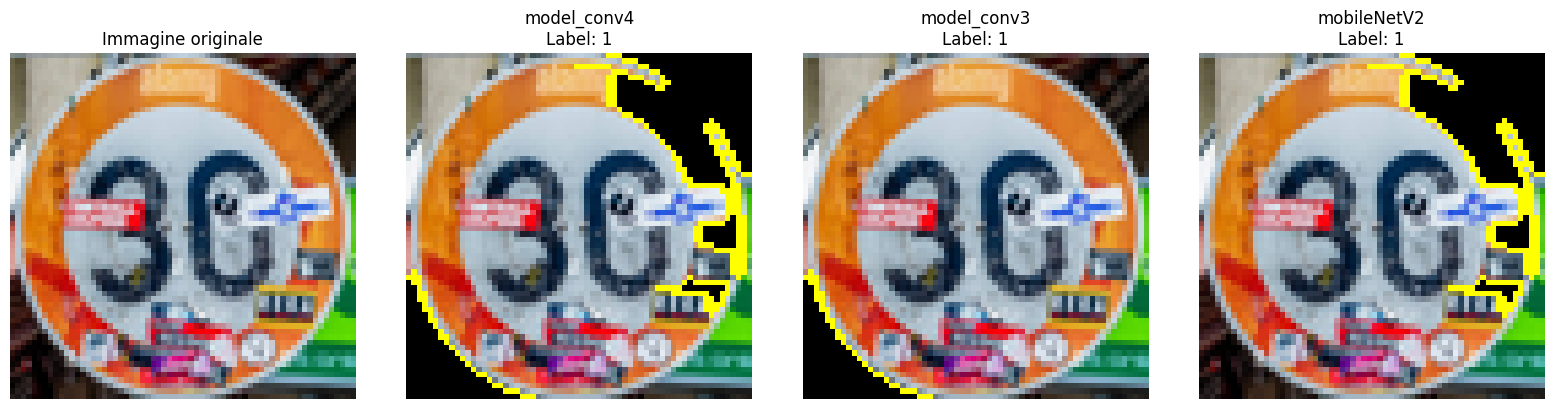

In [29]:
#explain_and_show_all_models(f"{TEST_PATH}/02/221819989748296_1.jpg", models_info)
explain_and_show_all_models(f"/workspace/test_LIME.jpg", models_info)

# Studio disomogeneità geografiche

Accuracy by income quartile
        modello quartile  accuracy  precision    recall        f1
0   model_conv4       Q1  0.998328   0.999412  0.985294  0.989899
1   model_conv4       Q2  0.981513   0.913667  0.917607  0.914539
2   model_conv4       Q3  0.996485   0.991793  0.995160  0.992855
3   model_conv4       Q4  0.980392   0.975561  0.954347  0.957264
4   model_conv3       Q1  1.000000   1.000000  1.000000  1.000000
5   model_conv3       Q2  0.989916   0.921347  0.936499  0.927523
6   model_conv3       Q3  0.998243   0.999704  0.999322  0.999509
7   model_conv3       Q4  0.993464   0.983839  0.982684  0.979296
8   mobileNetV2       Q1  0.998328   0.997059  0.998869  0.997875
9   mobileNetV2       Q2  0.991597   0.959709  0.962789  0.960465
10  mobileNetV2       Q3  0.996485   0.997585  0.995160  0.996207
11  mobileNetV2       Q4  0.996732   0.998926  0.989286  0.993135


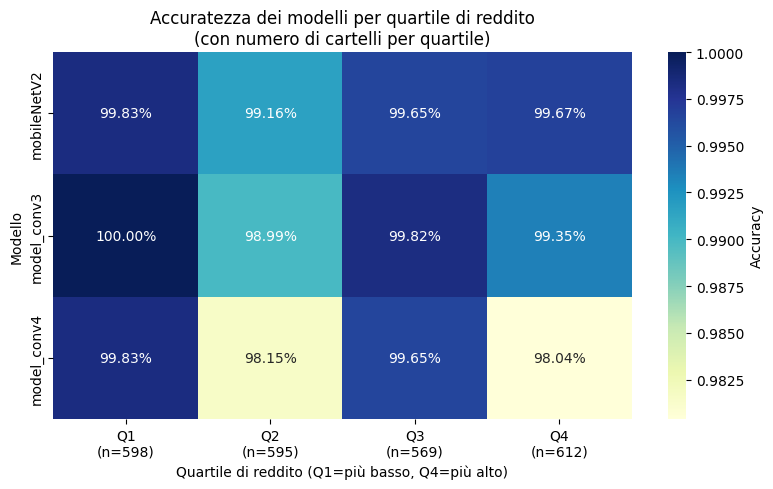

Accuracy by area
       modello    area  accuracy  precision    recall        f1
0  model_conv4    nord  0.984332   0.981414  0.940731  0.953465
1  model_conv4  centre  0.991209   0.932988  0.921954  0.924675
2  model_conv4     sud  0.994005   0.995709  0.981381  0.985999
3  model_conv3    nord  0.994470   0.973897  0.968072  0.968310
4  model_conv3  centre  0.993407   0.963001  0.967514  0.964993
5  model_conv3     sud  0.997602   0.998417  0.991497  0.994417
6  mobileNetV2    nord  0.994470   0.991896  0.977785  0.982720
7  mobileNetV2  centre  0.995604   0.996506  0.983983  0.987643
8  mobileNetV2     sud  0.997602   0.994286  0.996190  0.994837


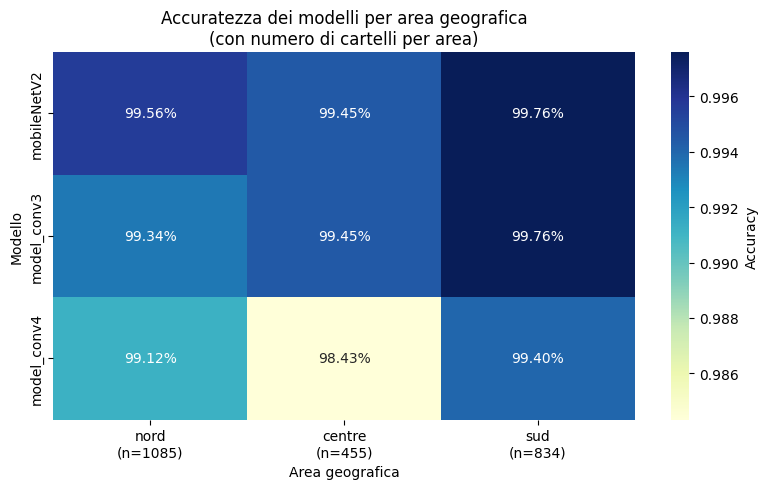

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

def build_paths(df, base_path='./'):
    return [
        os.path.join(base_path, f"{row['feature_index']:02d}", row['filename'])
        for _, row in df.iterrows()
    ]

def get_predictions_from_paths(model, image_paths):
    data = []
    for img_path in image_paths:
        img = process_image(img_path)
        if img is not None:
            data.append(img)
        else:
            data.append(np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8))
    X = np.array(data, dtype=np.float32) / 255.0
    preds = np.argmax(model.predict(X, verbose=0), axis=-1)
    return preds

def get_metadata_test_with_geo_labels():
    sign_info = pd.read_parquet(f'{DATA_DIR}/metadata.parquet')
    sign_info = sign_info.loc[sign_info['split'] == 'test']
    sign_info[['lat', 'lon']] = sign_info['coordinates'].str.split(",", expand=True).astype(float)
    return sign_info


def report_accuracy_by_area():
    sign_info = get_metadata_test_with_geo_labels()

    area_dfs = {
        'nord': sign_info[sign_info['area'] == 'nord'],
        'centre': sign_info[sign_info['area'] == 'centre'],
        'sud': sign_info[sign_info['area'] == 'sud']
    }

    # Calcolo metriche per modello e area
    accuracy_results = []

    for model_name, info in models_info.items():
        model = info['model']
        for area_name, df_area in area_dfs.items():
            image_paths = build_paths(df_area, TEST_PATH)
            preds = get_predictions_from_paths(model, image_paths)
            true_labels = df_area['feature_index'].values

            acc = np.mean(preds == true_labels)
            report = classification_report(true_labels, preds, output_dict=True, zero_division=0)
            precision = report['macro avg']['precision']
            recall = report['macro avg']['recall']
            f1 = report['macro avg']['f1-score']

            accuracy_results.append({
                'modello': model_name,
                'area': area_name,
                'accuracy': acc,
                'precision': precision,
                'recall': recall,
                'f1': f1
            })

    results_df = pd.DataFrame(accuracy_results)
    results_df.pivot(index='modello', columns='area', values='accuracy')
    return results_df, area_dfs

def report_accuracy_by_income_quartile():
    sign_info = get_metadata_test_with_geo_labels()
    
    # Filtra e raggruppa per quartile di reddito (Q1-Q4)
    quartile_dfs = {
        f'Q{i}': sign_info[sign_info['income_quartile'] == f'Q{i}']
        for i in range(1, 5)
    }

    # Calcolo metriche per modello e quartile
    accuracy_results = []

    for model_name, info in models_info.items():
        model = info['model']
        for quartile_name, df_quartile in quartile_dfs.items():
            image_paths = build_paths(df_quartile, TEST_PATH)
            preds = get_predictions_from_paths(model, image_paths)
            true_labels = df_quartile['feature_index'].values

            acc = np.mean(preds == true_labels)
            report = classification_report(true_labels, preds, output_dict=True, zero_division=0)
            precision = report['macro avg']['precision']
            recall = report['macro avg']['recall']
            f1 = report['macro avg']['f1-score']

            accuracy_results.append({
                'modello': model_name,
                'quartile': quartile_name,
                'accuracy': acc,
                'precision': precision,
                'recall': recall,
                'f1': f1
            })

    results_df = pd.DataFrame(accuracy_results)
    return results_df, quartile_dfs


def plot_income_quartile_accuracy():
    accuracy_by_quartile_df, quartile_dfs = report_accuracy_by_income_quartile()
    print('Accuracy by income quartile')
    print(accuracy_by_quartile_df)
    # Conteggio cartelli per quartile
    quartile_counts = {quartile: len(df) for quartile, df in quartile_dfs.items()}
    
    # Pivot per heatmap
    heatmap_data = accuracy_by_quartile_df.pivot(index='modello', columns='quartile', values='accuracy')
    
    # Etichette con numero di cartelli
    quartile_labels = [f"{quartile}\n(n={quartile_counts[quartile]})" for quartile in quartile_counts]
    heatmap_data.columns = quartile_labels
    
    # Plot
    plt.figure(figsize=(8, 5))
    sns.heatmap(heatmap_data, annot=True, fmt=".2%", cmap="YlGnBu", cbar_kws={'label': 'Accuracy'})
    plt.title("Accuratezza dei modelli per quartile di reddito\n(con numero di cartelli per quartile)")
    plt.xlabel("Quartile di reddito (Q1=più basso, Q4=più alto)")
    plt.ylabel("Modello")
    plt.tight_layout()
    plt.show()

def plot_area_accuracy():
    accuracy_by_area_df, area_dfs = report_accuracy_by_area()
    print('Accuracy by area')
    print(accuracy_by_area_df)
    # Calcolo conteggio cartelli per area
    area_counts = {area: len(df) for area, df in area_dfs.items()}

    # Pivot per heatmap
    heatmap_data = accuracy_by_area_df.pivot(index='modello', columns='area', values='accuracy')

    # Etichette con numero cartelli da usare come annotazioni o titolo
    area_labels = [f"{area}\n(n={count})" for area, count in area_counts.items()]
    heatmap_data.columns = area_labels  # aggiorna colonne con annotazioni

    # Plot della heatmap
    plt.figure(figsize=(8, 5))
    sns.heatmap(heatmap_data, annot=True, fmt=".2%", cmap="YlGnBu", cbar_kws={'label': 'Accuracy'})
    plt.title("Accuratezza dei modelli per area geografica\n(con numero di cartelli per area)")
    plt.xlabel("Area geografica")
    plt.ylabel("Modello")
    plt.tight_layout()
    plt.show()

plot_income_quartile_accuracy()
plot_area_accuracy()

## Reports

I seguenti report sono adoperati per applicare una analisi statica rigorosa con seguenti test applicati per tutte le coppie delle macroaree (nord, sud), (nord, centro), (centro, sud):
- Test di normalità (Shapiro-Wilk)
- Test parametrici (t-test) e non parametrici (Mann-Whitney) appropriati

Le valutazioni sono compiute sull'analisi di eventuali bias geografici che socio-economici. Questi ultimi sono derivati leggendo il reddito medio per contribuente indicizzato per ogni comune italiano nel quale ricade almeno un cartello stradale riconosciuto.

In [55]:
def cliffs_delta(x, y):
    """
    Calcola Cliff's Delta tra due distribuzioni x e y.
    Restituisce delta e interpretazione qualitativa.
    """
    # Calcolo tutte le coppie
    more = sum(a > b for a in x for b in y)
    less = sum(a < b for a in x for b in y)
    delta = (more - less) / (len(x) * len(y))
    
    # Interpretazione qualitativa (Romano et al., 2006)
    abs_delta = abs(delta)
    if abs_delta < 0.147:
        size = "negligible"
    elif abs_delta < 0.33:
        size = "small"
    elif abs_delta < 0.474:
        size = "medium"
    else:
        size = "large"
    
    return delta, size


In [56]:
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
from pathlib import Path

def get_test_results(model):
    """
    Restituisce un DataFrame con:
    - filename
    - true_label
    - predicted_label
    - confidence
    - prediction_correct (boolean)
    """
    filenames, true_labels = [], []
    for label_name in os.listdir(TEST_PATH):
        label_dir = os.path.join(TEST_PATH, label_name)
        if os.path.isdir(label_dir):
            for img_path in glob.glob(os.path.join(label_dir, '*')):
                filenames.append(Path(img_path).name)
                true_labels.append(int(label_name))

    # Previsione
    pred_probs, _ = get_confidence(model)
    predictions = np.argmax(pred_probs, axis=-1)
    confidences = np.max(pred_probs, axis=-1)

    # Costruzione DataFrame
    results = pd.DataFrame({
        "filename": filenames,
        "true_label": true_labels,
        "predicted_label": predictions,
        "confidence": confidences,
        "prediction_correct": predictions == true_labels
    })

    return results


def filter_by_correctness(df, correct=True):
    """
    Restituisce solo le righe con predizioni corrette o errate
    """
    return df[df["prediction_correct"] == correct].copy()

def is_normal_distribution(distribution):
    if len(distribution) <= 5000:
        return shapiro(distribution)  
    else:
        print(f"distribution's len is {len(distribution)}, apply alternative method to shapiro")
        return None

def compare_groups(df: pd.DataFrame, col_group: str, group1, group2):
    """
    Esegue test di normalità e confronto (t-test o Mann-Whitney)
    Calcola anche Cliff's Delta.
    """
    conf_a = df[df[col_group] == group1]["confidence"]
    conf_b = df[df[col_group] == group2]["confidence"]

    normal_a = is_normal_distribution(conf_a)
    normal_b = is_normal_distribution(conf_b)

    if normal_a and normal_b:
        stat, pval = ttest_ind(conf_a, conf_b, equal_var=False)
        test_used = "T-Test"
    else:
        stat, pval = mannwhitneyu(conf_a, conf_b)
        test_used = "Mann-Whitney"

    delta, effect_size = cliffs_delta(conf_a, conf_b)
    
    return {
        "gruppo_1": group1,
        "gruppo_2": group2,
        "normalità_1": normal_a,
        "normalità_2": normal_b,
        "test": test_used,
        "statistica": stat,
        "p_value": pval,
        "cliffs_delta": delta,
        "effect_size": effect_size
    }


def run_all_couple_comparisons(df: pd.DataFrame, col_group: str) -> pd.DataFrame:
    """
    Esegue confronti statistici per tutte le coppie del gruppo specificato
    Le coppie possono essere macro-area (es.: (nord, sud)) oppure quartili di reddito (es.: (Q1, Q4))
    """
    risultati: list = []
    gruppi: list = sorted(df[col_group].unique())
    for i in range(len(gruppi)):
        for j in range(i+1, len(gruppi)):
            g1, g2 = gruppi[i], gruppi[j]
            res = compare_groups(df, col_group, g1, g2)
            risultati.append(res)
    return pd.DataFrame(risultati)

def analyze_models(models_info):
    # carica metadati
    metadata_df = get_metadata_test_with_geo_labels()
    
    all_geo_results = []
    all_income_results = []
    all_correct_dfs = []
    
    for model_name, model_data in models_info.items():
        current_model = model_data['model']
        
        # df con: filename, true_labels, predicted_labels, confidence, prediction_correct (bool)
        results_df = get_test_results(current_model)
        # join dei df
        full_df = pd.merge(results_df, metadata_df, on="filename", how="inner")
        # df con solo le predizioni corrette
        correct_df = filter_by_correctness(full_df, correct=True)
        
        # Step 5-6: esegui analisi e aggiungi identificativo
        geo_df = run_all_couple_comparisons(correct_df, "area")
        geo_df['model_name'] = model_name
        
        income_df = run_all_couple_comparisons(correct_df, "income_quartile")
        income_df['model_name'] = model_name

        correct_df['model_name'] = model_name

        all_correct_dfs.append(correct_df)
        all_geo_results.append(geo_df)
        all_income_results.append(income_df)

    # Combina risultati di tutti i modelli
    final_geo = pd.concat(all_geo_results, ignore_index=True)
    final_income = pd.concat(all_income_results, ignore_index=True)
    all_correct_df = pd.concat(all_correct_dfs, ignore_index=True)
    
    return final_geo, final_income, all_correct_df

In [57]:
all_geo_df, all_income_df, all_correct_df = analyze_models(models_info)

74/74 [==============================] - 2s 28ms/step


Save dataframe reports

In [58]:
all_geo_df.to_parquet(f"{WORSPACE_PATH}/geographic_report.parquet", index=False)
all_income_df.to_parquet(f"{WORSPACE_PATH}/income_report.parquet", index=False)
all_correct_df.to_parquet(f"{WORSPACE_PATH}/predictions_report.parquet", index=False)

### Show reports result

In [59]:
import seaborn as sns

def plot_models_comparison_grid(df: pd.DataFrame, col_group, plot_type='box', fig_width=20):
    """
    Crea una griglia orizzontale di grafici, uno per modello.
    Inoltre stampa le statistiche globali delle confidenze per ciascun modello.
    
    Parametri:
    - df: DataFrame con i dati
    - col_group: colonna di raggruppamento ('area' o 'income_quartile')
    - plot_type: 'box', 'violin' o 'bar'
    - fig_width: larghezza totale della figura
    """
    # Filtraggio unico dei modelli
    models = df['model_name'].unique()
    n_models = len(models)
    
    fig, axes = plt.subplots(
        1, n_models, 
        figsize=(fig_width, 5),
        sharey=True
    )
    
    if n_models == 1:
        axes = [axes]

    unique_groups = df[col_group].unique()
    palette = sns.color_palette("coolwarm", len(unique_groups))

    print("Statistiche globali delle confidenze per ciascun modello:\n")

    for i, model in enumerate(models):
        ax = axes[i]
        model_df = df[df['model_name'] == model]
        model_df = model_df.drop_duplicates(subset=['filename', col_group])
        
        # Statistiche globali
        mean_conf = model_df['confidence'].mean()
        std_conf = model_df['confidence'].std()
        min_conf = model_df['confidence'].min()
        max_conf = model_df['confidence'].max()

        print(f"{model}:")
        print(f"  Media      : {mean_conf:.3f}")
        print(f"  Dev.Std.   : {std_conf:.3f}")
        print(f"  Min        : {min_conf:.3f}")
        print(f"  Max        : {max_conf:.3f}\n")

        # Plot
        if plot_type == 'box':
            sns.boxplot(
                data=model_df, 
                x=col_group, 
                y='confidence', 
                hue=col_group,  
                palette=palette,
                ax=ax,
                legend=True,    
                width=0.7
            )
        elif plot_type == 'violin':
            sns.violinplot(
                data=model_df, 
                x=col_group, 
                y='confidence', 
                hue=col_group,  
                palette=palette,
                ax=ax,
                inner='quartile',
                legend=True,    
                cut=0
            )
        elif plot_type == 'bar':
            sns.barplot(
                data=model_df, 
                x=col_group, 
                y='confidence', 
                hue=col_group,  
                palette=palette,
                ax=ax,
                errorbar='sd',
                capsize=0.1,
                legend=True     
            )

        ax.axhline(
            y=mean_conf, 
            color='red', 
            linestyle='--', 
            linewidth=1.5,
            alpha=0.7,
            label=f'Media: {mean_conf:.3f}'
        )

        # Titolo con statistiche
        ax.set_title(
            f'{model}\nμ={mean_conf:.2f} σ={std_conf:.2f}', 
            fontsize=13
        )
        
        ax.set_xlabel(col_group if i == n_models//2 else '')
        ax.set_ylabel('Confidenza' if i == 0 else '')
        ax.grid(axis='y', alpha=0.3)

    plt.suptitle(f'Confronto confidenza per {col_group}', fontsize=16, y=1.05)
    plt.tight_layout()



def plot_income_geo_compare_distribution(df_geo, df_income):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # Stessa scala Y
    
    # Plot per bias geografico
    sns.boxplot(
        data=df_geo, 
        x='test', 
        y='p_value', 
        hue='model_name', 
        ax=ax[0],
        palette='coolwarm',
        width=0.6,
        legend=False
    )
    ax[0].axhline(0.05, color='r', linestyle='--', linewidth=1)
    ax[0].set_title('Distribuzione p-value - Bias Geografico', pad=20)
    ax[0].set_ylabel('p-value')
    ax[0].grid(axis='y', alpha=0.3)
    
    # Plot per bias reddituale
    sns.boxplot(
        data=df_income, 
        x='test', 
        y='p_value', 
        hue='model_name', 
        ax=ax[1],
        palette='coolwarm',
        width=0.6
    )
    ax[1].axhline(0.05, color='r', linestyle='--', linewidth=1)
    ax[1].set_title('Distribuzione p-value - Bias Reddituale', pad=20)
    ax[1].grid(axis='y', alpha=0.3)
    
    # Linea di significatività comune
    for a in ax:
        a.set_ylim(-0.02, 1.02)  # Range fisso 0-1
        a.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    
    plt.tight_layout()
    plt.show()

Statistiche globali delle confidenze per ciascun modello:

model_conv4:
  Media      : 0.998
  Dev.Std.   : 0.020
  Min        : 0.607
  Max        : 1.000

model_conv3:
  Media      : 0.995
  Dev.Std.   : 0.036
  Min        : 0.434
  Max        : 1.000

mobileNetV2:
  Media      : 0.999
  Dev.Std.   : 0.011
  Min        : 0.640
  Max        : 1.000

Statistiche globali delle confidenze per ciascun modello:

model_conv4:
  Media      : 0.998
  Dev.Std.   : 0.020
  Min        : 0.607
  Max        : 1.000

model_conv3:
  Media      : 0.995
  Dev.Std.   : 0.036
  Min        : 0.434
  Max        : 1.000

mobileNetV2:
  Media      : 0.999
  Dev.Std.   : 0.011
  Min        : 0.640
  Max        : 1.000

Statistiche globali delle confidenze per ciascun modello:

model_conv4:
  Media      : 0.998
  Dev.Std.   : 0.020
  Min        : 0.607
  Max        : 1.000

model_conv3:
  Media      : 0.995
  Dev.Std.   : 0.036
  Min        : 0.434
  Max        : 1.000

mobileNetV2:
  Media      : 0.999
  Dev

/tmp/ipykernel_9/2360616509.py:146: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  a.legend(loc='upper right', bbox_to_anchor=(1.2, 1))


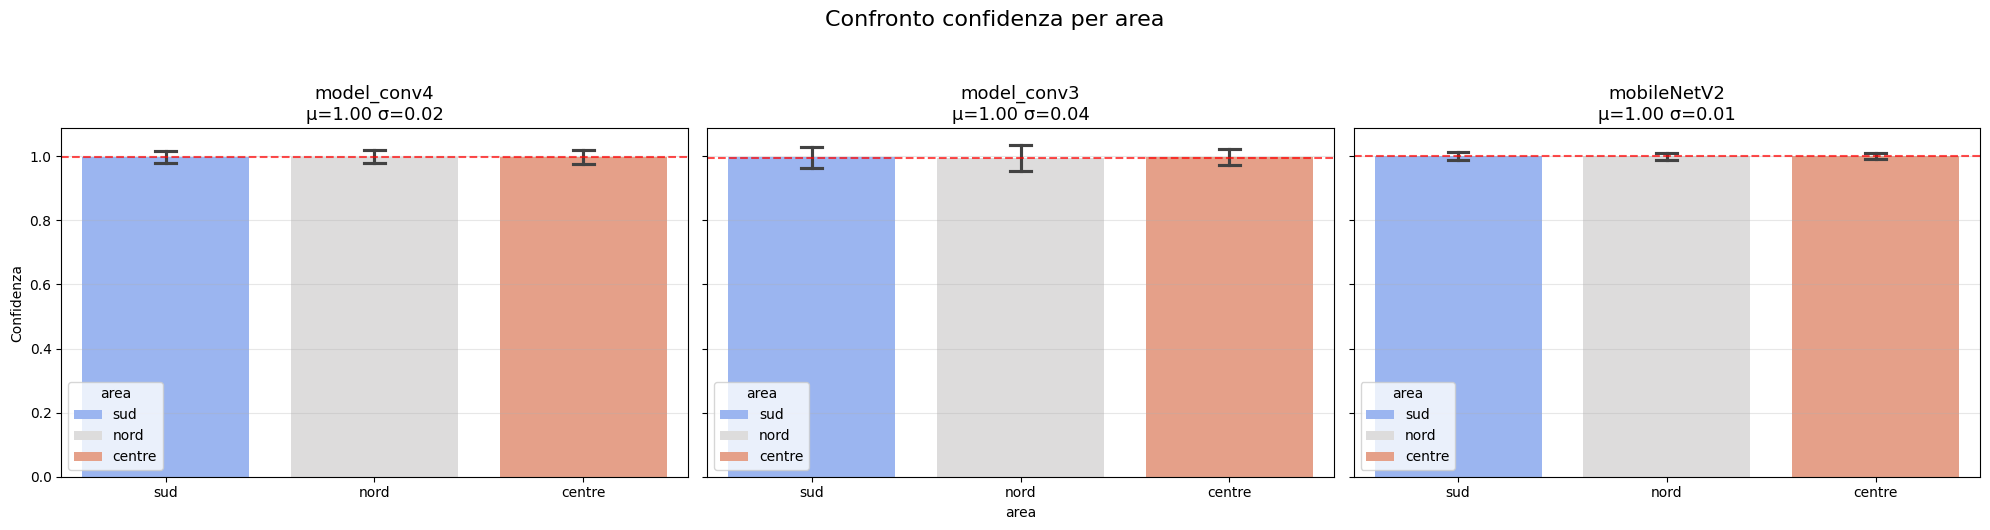

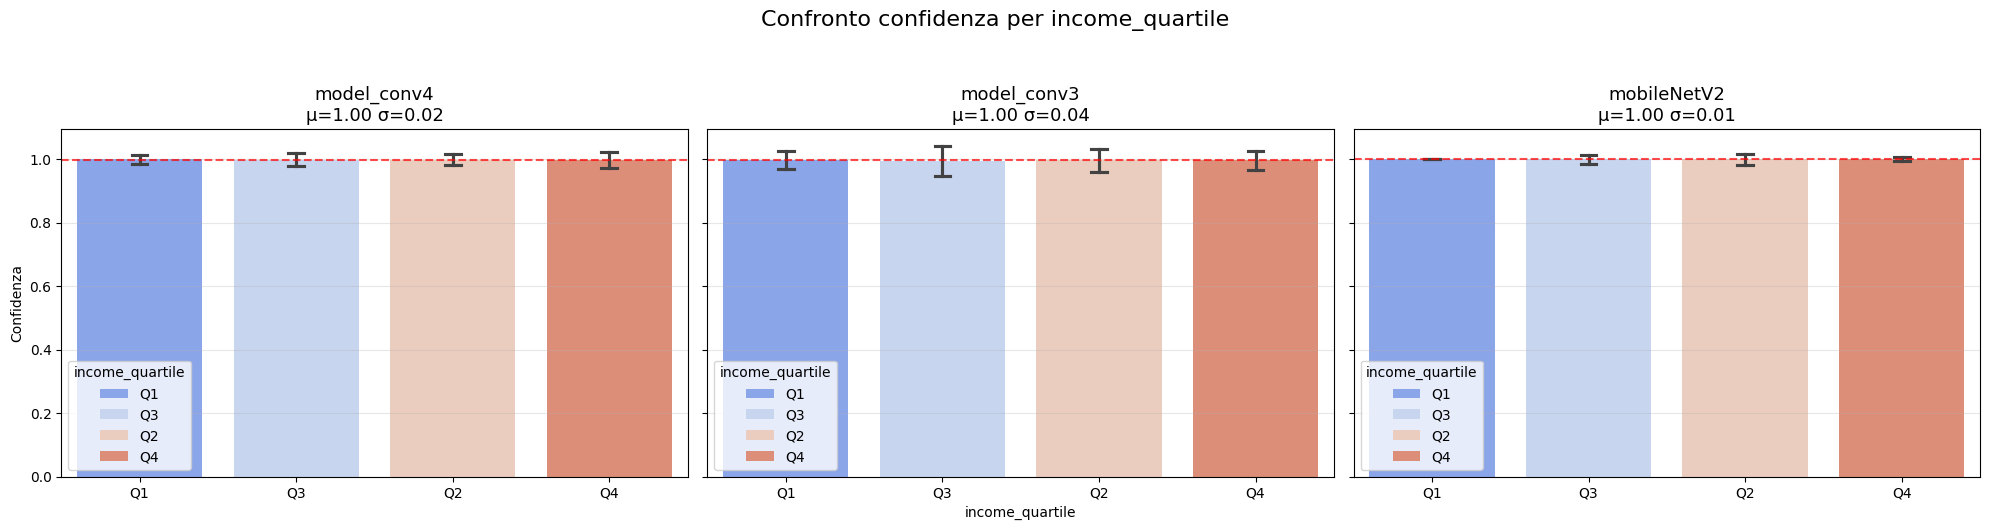

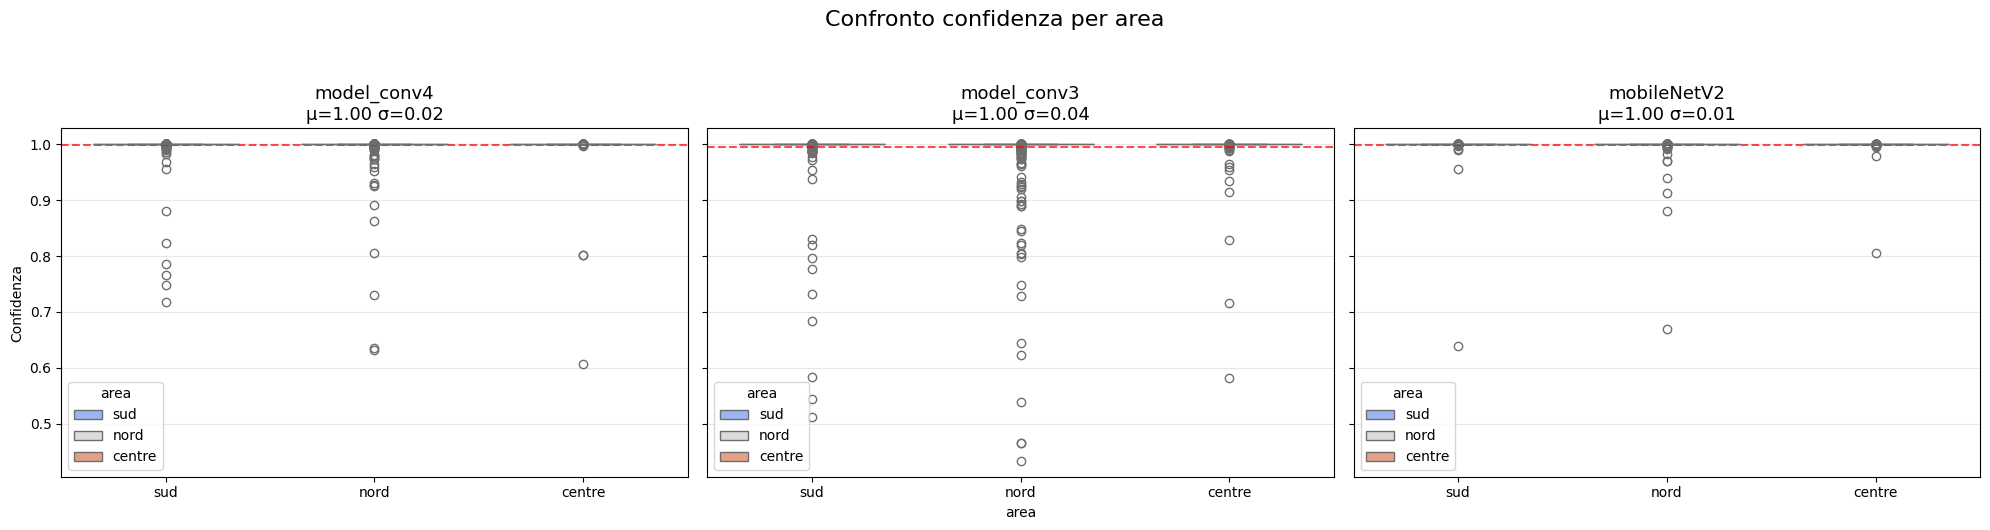

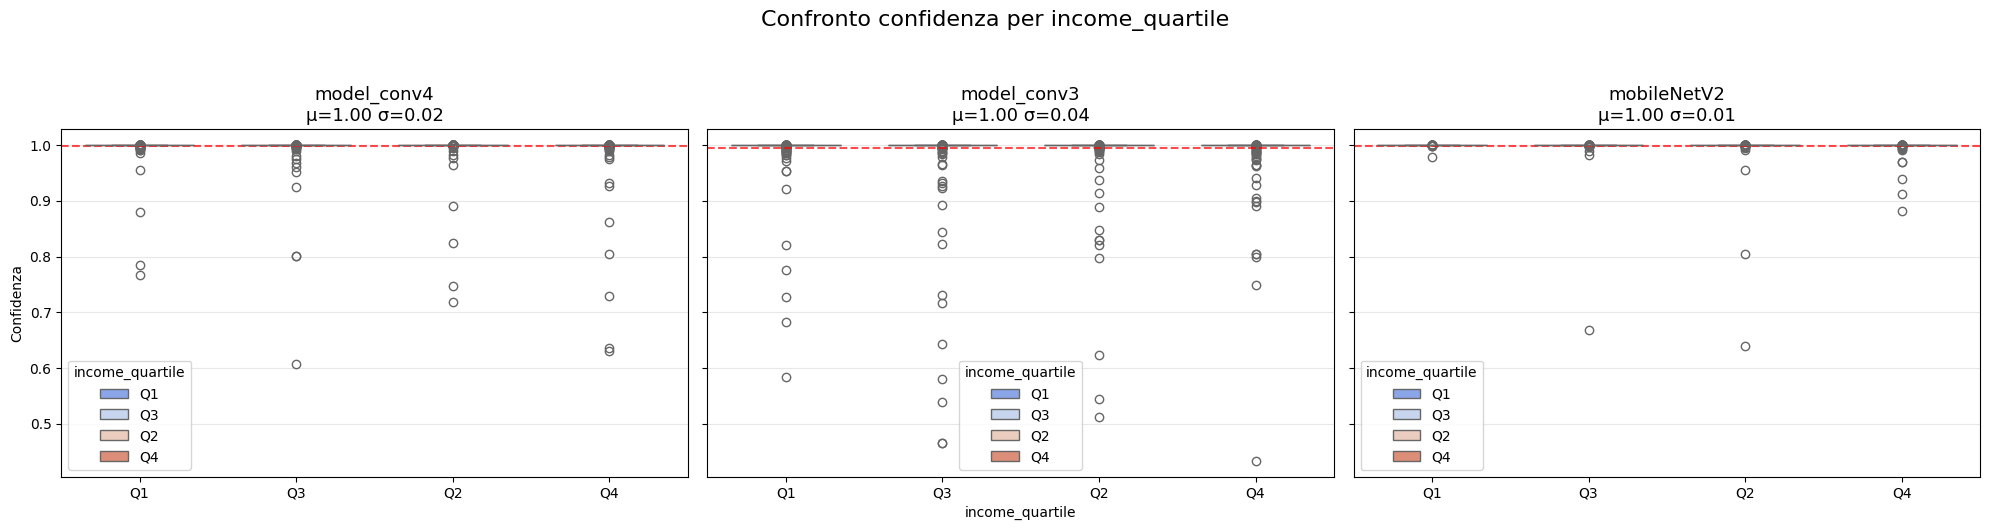

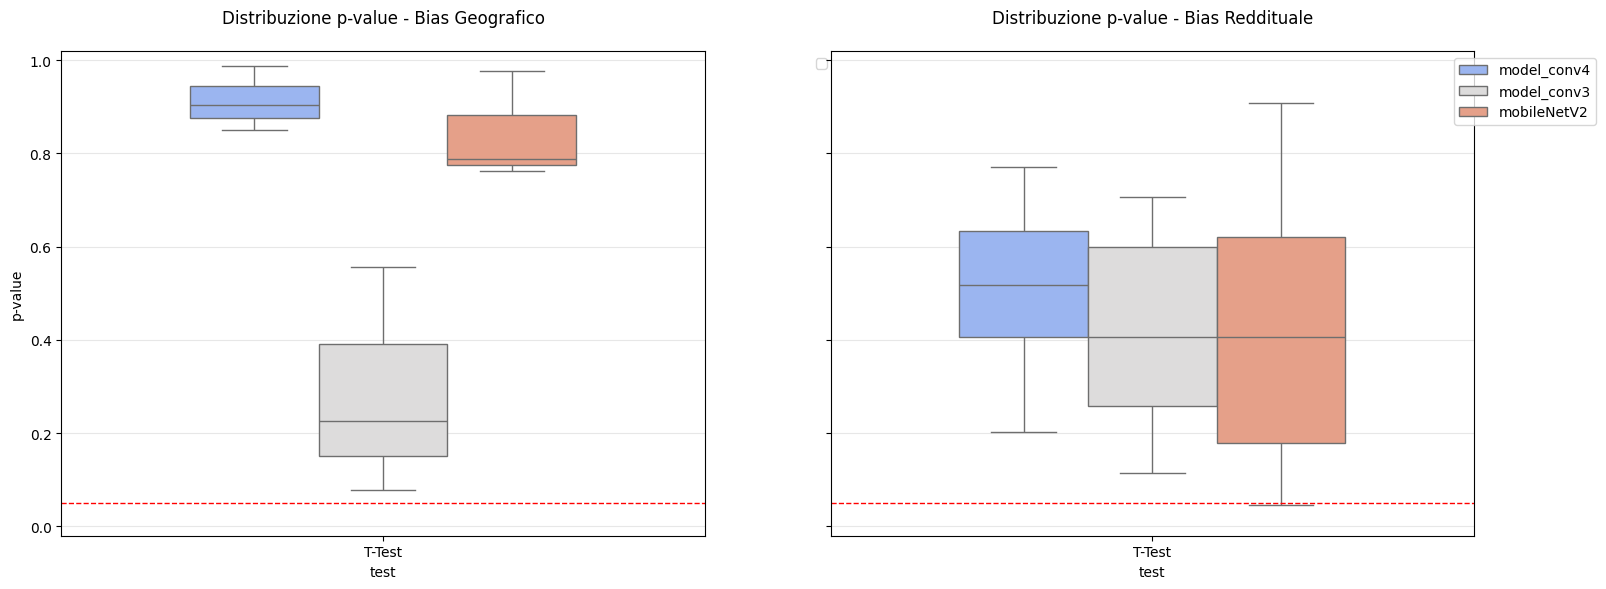

In [60]:
plot_models_comparison_grid(all_correct_df, 'area', plot_type='bar')
plot_models_comparison_grid(all_correct_df, 'income_quartile', plot_type='bar')

plot_models_comparison_grid(all_correct_df, 'area', plot_type='box')
plot_models_comparison_grid(all_correct_df, 'income_quartile', plot_type='box')

plot_income_geo_compare_distribution(all_geo_df, all_income_df)

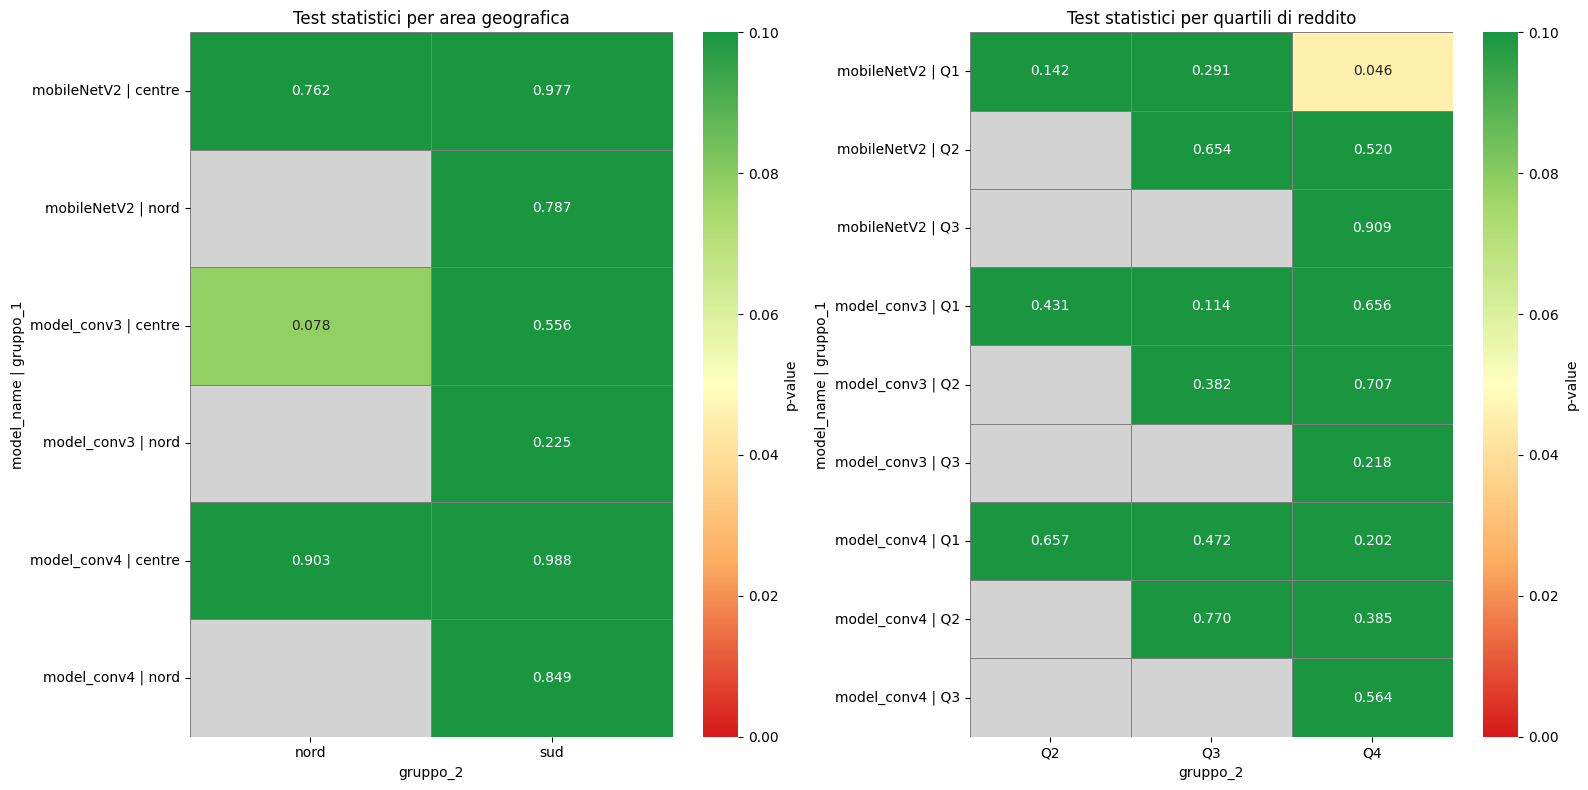

In [61]:
from matplotlib.colors import LinearSegmentedColormap

def plot_statistical_tests():
    """
    Visualizza i risultati dei test statistici tramite heatmap e barplot annotati.
    Utilizza direttamente all_geo_df e all_income_df definiti globalmente.
    """
    # Usa direttamente i dataframe globali
    geo_df = all_geo_df
    income_df = all_income_df

    plt.figure(figsize=(16, 8))

    # Heatmap p-value per area geografica
    plt.subplot(1, 2, 1)
    plot_heatmap(geo_df, "model_name", "gruppo_1", "gruppo_2", "p_value",
                 "Test statistici per area geografica")

    # Heatmap p-value per quartili di reddito
    plt.subplot(1, 2, 2)
    plot_heatmap(income_df, "model_name", "gruppo_1", "gruppo_2", "p_value",
                 "Test statistici per quartili di reddito")

    plt.tight_layout()
     
    plt.savefig(os.path.join(WORSPACE_PATH, "p_values_heatmaps.png"), dpi=300, transparent=True, bbox_inches="tight")
    plt.show()

def plot_heatmap(df, model_col, group1_col, group2_col, value_col, title):
    """Genera una heatmap dei valori statistici con celle grigio chiaro per valori mancanti."""
    # Crea colonna che concatena i livelli per semplificare l'indice
    df = df.copy()
    df['combined_index'] = df[model_col].astype(str) + " | " + df[group1_col].astype(str)

    # Pivot: righe = combined_index, colonne = gruppo_2
    pivot_df = df.pivot_table(values=value_col,
                              index='combined_index',
                              columns=group2_col)

    # Crea colormap personalizzata
    cmap = LinearSegmentedColormap.from_list(
        'pvalue_cmap', ['#d7191c', '#fdae61', '#ffffbf', '#a6d96a', '#1a9641'])

    # Crea mappa per i valori mancanti: colori grigio chiaro
    # Imposta il colore per NaN
    cmap.set_bad(color='lightgrey')

    # Plot heatmap
    ax = plt.gca()
    sns.heatmap(pivot_df, annot=True, fmt=".3f", cmap=cmap,
                center=0.05, vmin=0, vmax=0.1,
                linewidths=.5, linecolor='gray',
                cbar_kws={'label': 'p-value'},
                square=False,
                mask=pivot_df.isna(),
                ax=ax)

    ax.set_title(title)
    ax.set_xlabel(group2_col)
    ax.set_ylabel(model_col + " | " + group1_col)

# Esempio di utilizzo
plot_statistical_tests()

In [31]:
from scipy.stats import ks_2samp

# Confronta distribuzioni dei p-value
ks_stat, ks_p = ks_2samp(
    all_geo_df['p_value'],
    all_income_df['p_value']
)

print(f"Test KS: statistic={ks_stat:.3f}, p-value={ks_p:.3f}")

Test KS: statistic=0.389, p-value=0.306


<Axes: >

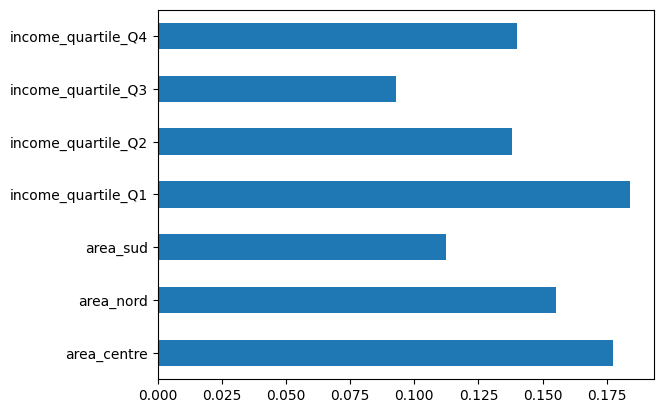

In [32]:
from sklearn.ensemble import RandomForestClassifier

# Preparazione dati
X = all_correct_df[['area', 'income_quartile']]
X = pd.get_dummies(X)
y = all_correct_df['confidence'] > all_correct_df['confidence'].median()

# Modello interpretativo
rf = RandomForestClassifier().fit(X, y)
pd.Series(rf.feature_importances_, index=X.columns).plot.barh()